# 3D Poission sin：
$$\frac{\partial^2u}{\partial x^2}+\frac{\partial^2u}{\partial y^2}+\frac{\partial^2u}{\partial z^2}+2\pi^2sin(\pi x)sin(\pi y)sin(\pi z)=0$$
解的形式：
$$sin(\pi x)sin(\pi y)sin(\pi z)$$
边界：
$$x\in[0,1]$$
$$y\in[0,1]$$
$$z\in[0,1]$$
边界条件：
$$u(x,y,z)=0$$
初始条件：无

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np
import tensorflow as tf


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.




In [2]:
# Problem parameters:
x_min, y_min, z_min = 0,0,0
x_max, y_max, z_max = 1,1,1

lr = 1e-3
iterations = 20000
data_path_name = "./Poission/poission2_3d"
input_num = 3
net_node = 50
layers = 3

num_domain=256 # 用于描述域内的点的数量
num_boundary=32 # 用于描述边界上的点的数量
num_test=256 # 用于描述测试点的数量

In [3]:
def gen_testdata(path_name):
    """Import and preprocess the dataset with the exact solution."""
    data = np.load(path_name+".npz")
    # Obtain the values for t, x, and the excat solution:
    x, y, z, exact = data["x1"],data["x2"], data["x3"], data["usol"]
    # Process the data and flatten it out (like labels and features):
    xx, yy, zz= np.meshgrid(x, y, z) # meshgrid：生成网格点坐标矩阵
    X = np.vstack((np.ravel(xx), np.ravel(yy),np.ravel(zz))).T # ravel：将多维数组降为一维
    y = exact.flatten()[:, None]
    return X, y

# 定义PDE
def pde(x, y):
    """
        Expresses the PDE residual of the heat equation.
    """
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    dy_zz = dde.grad.hessian(y, x, i=2, j=2)
    return  -dy_xx -dy_yy -dy_zz- np.pi ** 3 * tf.sin(np.pi * x[:,0:1]) * tf.sin(np.pi * x[:,1:2]) * tf.sin(np.pi * x[:,2:3])

def func(x):
    return np.sin(np.pi * x[:,0:1])*np.sin(np.pi * x[:,1:2])*np.sin(np.pi * x[:,2:3])

In [ ]:
geom = dde.geometry.Cuboid([x_min, y_min, z_min], [x_max, y_max, z_max])
bc = dde.icbc.DirichletBC(geom, func, lambda _,on_boundary:on_boundary) # 直接使用func和令边界值为0相同

# 数据作为model的输入
data = dde.data.PDE(
    geom, # 用于描述空间和时间的几何形状
    pde, # 用于描述PDE的函数
    [bc], # 用于描述边界和初始条件的列表
    num_domain=num_domain, # 用于描述域内的点的数量
    num_boundary=num_boundary, # 用于描述边界上的点的数量
    num_test=num_test, # 用于描述测试点的数量
)
# 定义网络，修改第1和最后一个参数，以及选择tanh或sigmoid作为激活函数
net = dde.nn.FNN([input_num] + [net_node] * layers + [1], "tanh", "Glorot normal")# 变量，神经元，隐藏层，输出，
    # Glorot normal: 一种初始化方法
model = dde.Model(data, net)


In [5]:
# 训练模型：先利用Adam进行训练，然后用L-BFGS进行训练
#快速降低损失
model.compile("adam", lr=lr) # 选择优化器和学习率
model.train(iterations=iterations) # 训练模型，迭代次数20000止
#精细调整
model.compile("L-BFGS") # 选择优化器
losshistory, train_state = model.train() # 训练模型

Compiling model...
Building feed-forward neural network...
'build' took 0.068628 s



/root/miniconda3/lib/python3.8/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-08-15 20:29:51.404454: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 20:29:52.347145: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-15 20:29:52.347684: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30279 MB memory:  -> device: 0, name: T

'compile' took 1.804852 s

Training model...



2023-08-15 20:29:53.156385: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-08-15 20:29:53.298395: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7f21e00090a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-15 20:29:53.298538: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-08-15 20:29:53.311538: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-15 20:29:55.118167: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss              Test loss               Test metric
0         [1.09e+02, 1.74e-02]    [1.81e+02, 1.74e-02]    []  
1000      [3.67e-02, 1.47e-02]    [4.69e-02, 1.47e-02]    []  
2000      [6.39e-03, 1.19e-03]    [1.25e-02, 1.19e-03]    []  
3000      [2.74e-03, 4.94e-04]    [5.39e-03, 4.94e-04]    []  
4000      [1.65e-03, 3.48e-04]    [3.77e-03, 3.48e-04]    []  
5000      [1.46e-02, 3.22e-04]    [1.91e-02, 3.22e-04]    []  
6000      [1.09e-03, 2.37e-04]    [2.89e-03, 2.37e-04]    []  
7000      [1.07e-03, 2.09e-04]    [2.69e-03, 2.09e-04]    []  
8000      [2.05e-03, 1.86e-04]    [3.95e-03, 1.86e-04]    []  
9000      [6.98e-04, 1.65e-04]    [2.24e-03, 1.65e-04]    []  
10000     [6.54e-03, 1.92e-04]    [8.97e-03, 1.92e-04]    []  
11000     [4.42e-04, 1.38e-04]    [1.84e-03, 1.38e-04]    []  
12000     [6.41e-04, 1.28e-04]    [1.86e-03, 1.28e-04]    []  
13000     [2.16e-03, 1.36e-04]    [3.56e-03, 1.36e-04]    []  
14000     [3.53e-04, 1.12e-04]    [1.63e-03, 1.1

2023-08-15 20:30:24.900265: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1750] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Step      Train loss              Test loss               Test metric
20000     [1.50e-03, 8.74e-05]    [2.67e-03, 8.74e-05]    []  
21000     [3.88e-05, 1.55e-05]    [3.88e-05, 1.55e-05]        
22000     [1.59e-05, 8.28e-06]    [1.59e-05, 8.28e-06]        
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000019
  Number of iterations: 2325
  Number of functions evaluations: 2435
22435     [1.32e-05, 6.21e-06]    [2.60e-04, 6.21e-06]    []  

Best model at step 22435:
  train loss: 1.94e-05
  test loss: 2.67e-04
  test metric: []

'train' took 25.034400 s



Saving loss history to /root/PINN/loss.dat ...
Saving training data to /root/PINN/train.dat ...
Saving test data to /root/PINN/test.dat ...


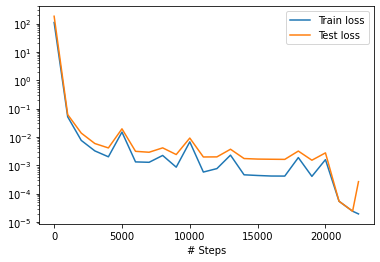

Mean Squared Error: 0.0008102946643942444
Mean Squared Error Variance: 0.0006478946257958103


In [6]:
# Plot/print the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True) # 保存损失函数图像
X, y_true = gen_testdata(data_path_name) # 生成测试数据
y_pred = model.predict(X) # 预测

# 计算均方误差
mse = dde.metrics.mean_squared_error(y_true, y_pred)
print("Mean Squared Error:", mse)
# 计算均方误差的方差
mse_variance = np.var(y_true - y_pred)
print("Mean Squared Error Variance:", mse_variance)